# Overview

This notebook provides an exploratory analysis of the optimal machine learning algorithm to use for hourly forecasts with limited training data.  The dataset is sourced from the HI-SEAS observation site in Hawaii, providing 5-minute-interval data from September through December.  The data is resampled to hourly intervals and then SARIMAX, Light GBM, and MLP neural networks are trained, tested, and compared.

Initial results suggest that ML algorithms are substantially superior to persistence models (~35 W/m2 RMSE improvement) and SARIMAX models (~50 W/m2 RMSE improvement).  Both Light GBM and MLP models learn the data quickly, suggesting they can be used with limited data and would require additional features to improve the model.  Previous 1-hour and previous 24-hour irradiance values, along with clear sky irradiance and temperature, appear to be the most important features in predicting irradiance one hour ahead.

Of not, the LGBM model appears to do better in exactly capturing the ~0 irradiance levels during nighttime, whereas the NN show jittery residuals during these times.  In contrast, the NN shows less dramatically high residuals during sharp changes in irradiance during the day.  Combining both LGBM and NN should then decrease variance since their errors occur in different parts of the feature parameter space.

UPDATE: changing activation function from identity to relu significantly improves NN performance, possibly by picking up nonlinearities between layers.

# Libraries

In [32]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPoly
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import seaborn as sns
%matplotlib inline
import datetime as dt
import re
import random

# Statsmodels imports (for ARIMA)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot

# Sklearn imports
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA

# Scikit-Optimize import
from skopt import BayesSearchCV
# Necessary for Bayes Search to work with scikit-learn 0.20
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

# PvLib imports
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.tmy import readtmy3
        
# Pandas display options
pd.set_option('max_columns', 200)

# Suppress warnings for now
import warnings
warnings.filterwarnings("ignore")

# Autoreload
import autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [2]:
def stationary_plot_and_test(df, colTS):
    '''
    Plot time-series data with rolling mean and perform Dickey-Fuller
    statistical test to determine if it's stationary.
    
    df: pandas dataframe
        dataframe with time-series data
    colTS: string
        column in df with time-series data
    '''
    
    rollMean = df[colTS].rolling(288).mean().dropna()
    rollStd = df[colTS].rolling(288).std().dropna()
    
    # Plot rolling stats with raw data
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(111)
    raw = ax1.plot(df[colTS], color='black', label='Raw data')
    mean = ax1.plot(rollMean, color='red', label='Rolling mean')
    std = ax1.plot(rollStd, color='blue', label='Rolling st. dev.')
    plt.legend(loc='best')
    
    # D-F Test
    test = adfuller(df[colTS], autolag='AIC')
    sOutput = pd.Series(test[0:4], index=['Test Statistic','p-value','Lags','Observations'])
    for key,value in test[4].items():
        sOutput['Critical Value (%s)'%key] = value
    
    print(sOutput)

In [3]:
def train_test_ts_end_split(df, colTS, testFrac):
    '''
    Creates train and test set for time series data
    by cutting off end percent of time series to serve as test set.
    '''
    
    trainSize = int((1.0-testFrac)*len(df))
    train, test = df[colTS].iloc[0:trainSize], df[colTS].iloc[trainSize:len(df)]
    
    return train, test

In [4]:
def out_of_sample_arima(df, colTS, train, test, model):
    '''
    Create loop to create train and test set and predict out-of-sample data elements.
    Works with statsmodels ARIMA and SARIMAX methods
    '''
    
    # Make predictions list
    pred = []
    
    # Loop through test data - do prediction, then append that test datum to training for next prediction
    print('Actual    Predict')
    for obs in range(len(test)):
        modO = model
        fit = modO.fit(disp=0)
        forecast = fit.forecast()
        yPred = forecast[0][0]
        pred.append(yPred)
        train.append(pd.Series(test.iloc[obs], index=[test.index.values[obs]]))
        print('{0:.2f}      {1:.2f}'.format(test.iloc[obs], yPred))

    error = mean_squared_error(test.values, pred)
    
    return fit, pred, error

In [5]:
def persistence_model(ts, steps, weights):
    '''
    Calculates forecast using weighted average of previous steps.
    
    Inputs
    ------
    ts: pandas Series
        input time-series used for training
    steps: list of n steps
        list of previous steps to use in persistence averaging
        e.g. [1, 12] would indicate to take the t-1 and t-12 steps
    weights: list n weights
        weights for each step in steps to calculate weighted average
        ith weight corresponds to ith step
        should sum to 1
    '''
    model = ts
    model = model-model
    for i, step in enumerate(steps):
        model += ts.shift(step)*weights[i]
    
    mse = mean_squared_error(ts[max(steps):len(ts)], model[max(steps):len(ts)])
    
    return model, mse

In [6]:
def learning_curve_plot(model, features, target, cvModel, trainFracs, scorer, nJobs,
                        plotTitle):
    '''
    Use sklearn's learning_curve method to plot model's learning curve to judge bias and variance.
    '''
    
    # Calculate learning curve data
    trainSizeLC, trainScoreLC, testScoreLC = learning_curve(model,
                                                           features, target,
                                                           train_sizes=trainFracs,
                                                           cv=cvModel,
                                                           scoring=scorer,
                                                           n_jobs=nJobs)
    # Plot results
    plt.figure(figsize=(10,5))

    # Calculate means and stds of cross-validated scores
    trainScoreLCmean = np.mean(trainScoreLC, axis=1)
    testScoreLCmean = np.mean(testScoreLC, axis=1)
    trainScoreLCstd = np.std(trainScoreLC, axis=1)
    testScoreLCstd = np.std(testScoreLC, axis=1)

    # Plot data
    plt.plot(trainSizeLC, trainScoreLCmean, 'o-', color='blue', label='Training')
    plt.plot(trainSizeLC, testScoreLCmean, 'o-', color='green', label='Test')
    plt.fill_between(trainSizeLC, trainScoreLCmean-trainScoreLCstd, trainScoreLCmean+trainScoreLCstd,
                     color='blue', alpha=0.25)
    plt.fill_between(trainSizeLC, testScoreLCmean-testScoreLCstd, testScoreLCmean+testScoreLCstd,
                     color='green', alpha=0.25)

    # Plot niceties
    plt.title("Learning Curve: {}".format(plotTitle))
    plt.xlabel("Number of training samples")
    plt.ylabel("Score: {}".format(scorer))
    plt.legend()
    
    return trainSizeLC, trainScoreLC, testScoreLC

In [93]:
def time_series_split_and_cv(features, target, nSplits, model, searchSpace, nCV, nIter, scaled=False):
    '''
    Splits data into increasing training intervals with test set immediately afterward.
    Then performs cross-validation using Bayesian search for each training set.
    Finally, predicts RMSE for each test set, returns average as final error prediction for model.
    This is a form of nested cross-validation for time-series data.
    
    Inputs
    ------
    features: pandas dataframe
        dataframe with all features as columns
    target: pandas dataframe
        dataframe with target variable as single column
    nSplits: int
        number of splits to create for test error calculation
    model: sklearn algorithm object
        model to be used for training (e.g. LGBMClassifier)
    SearchSpace: dict
        dictionary with parameters for Bayesian serach hyperparameter optimization
    nCV: int
        number of cross-validation folds
    nIter: int
        number of sequential Bayesian optimization steps
    scaled: boolean
        set to True to scale features using StandardScaler.
    
    Outputs
    -------
    sPred: pandas Series
    sResiduals: pandas Series
    listRMSE: python list
    gridBayes.best_params: python dict
    '''
    
    # Initialize list of test predictions for plotting and RMSE list for final average
    listPred = []
    listRMSE = []
    
    i=0
    for indexTrain, indexTest in TimeSeriesSplit(n_splits=nSplits).split(features):
        i+=1
        featTrainTS, featTestTS = features.iloc[indexTrain], features.iloc[indexTest]
        targTrainTS, targTestTS = target.iloc[indexTrain], target.iloc[indexTest]
        
        # Scale features if optional parameter set to True
        if scaled == True:
            ss = StandardScaler()
            ss.fit(featTrainTS)
            featTrainTS = pd.DataFrame(ss.transform(featTrainTS), columns=featTrainTS.columns)
            featTestTS = pd.DataFrame(ss.transform(featTestTS), columns=featTestTS.columns)
        
        # Bayesian hyperparameter optimization using training/validation sets
        gridBayes = BayesSearchCV(estimator=model,
                                     search_spaces=searchSpace,
                                     cv=nCV,
                                     scoring='neg_mean_squared_error',
                                     n_iter=nIter,
                                     return_train_score=True,
                                     n_jobs=1
                                    )
        gridBayes.fit(featTrainTS, targTrainTS)
        print('Split ' + str(i) + ' Best Parameters: {}'.format(gridBayes.best_params_))
        
        # Create model to use to predict test set
        modelFinal = model.set_params(**gridBayes.best_params_)
        modelFinal.fit(featTrainTS, targTrainTS)
        
        # Predict test values - append values to list and MSE to MSE list
        predictions = modelFinal.predict(featTestTS)
        listPred.extend(predictions)
        rmse = np.sqrt(mean_squared_error(targTestTS, predictions))
        listRMSE.append(rmse)
        print('Split ' + str(i) + ' Test RMSE: {0:.2f}'.format(rmse))
    
    # Calculate final average test RMSE
    rmseAvg = np.mean(listRMSE)
    rmseStd = np.std(listRMSE)
    print('Test RMSE Average: {0:.2f}+/-{1:.2f}'.format(rmseAvg, rmseStd))
    
    # Create series of predictions with datetimes
    # Index of first test prediction based on TimeSeriesSplit documentation
    indFirst = len(dfFeat) // (nSplits + 1) + len(dfFeat) % (nSplits + 1)
    sPred = pd.Series(listPred, index=features.index[indFirst:])
    
    # Calculate and return residuals as Series
    sResiduals = pd.Series((sPred-target.iloc[indFirst:]), index=target.index[indFirst:])
    
    return sPred, sResiduals, listRMSE, gridBayes.best_params_

# Load Data and Manipulate

In [8]:
# Load data
dfTS = pd.read_csv("SolarPrediction.csv")
print(len(dfTS))

32686


## Data Manipulation and Cleaning

Converting dates to datetime, resampling to 1-hour intervals.

In [9]:
# Convert UNIXTime to a regular datetime format
dfTS['Datetime'] = dfTS['UNIXTime'].apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
dfTS['Datetime'] = pd.to_datetime(dfTS['Datetime'])
dfTS['TimeSunRise'] = pd.to_datetime(dfTS['TimeSunRise'])
dfTS['TimeSunSet'] = pd.to_datetime(dfTS['TimeSunSet'])
dfTS = dfTS.sort_values('Datetime', ascending=True)

# Make datetime the df index
dfTS = dfTS.set_index('Datetime')

In [10]:
# Make separate features for hour, minute, second of sunrise and sunset
# --don't need seconds because always 0
dfTS['HourSunRise'] = dfTS['TimeSunRise'].apply(lambda x: x.hour)
dfTS['MinSunRise'] = dfTS['TimeSunRise'].apply(lambda x: x.minute)

dfTS['HourSunSet'] = dfTS['TimeSunSet'].apply(lambda x: x.hour)
dfTS['MinSunSet'] = dfTS['TimeSunSet'].apply(lambda x: x.minute)

In [11]:
# Drop other time columns because now unnecessary
dfTS.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

In [12]:
# Majority of time differences is 5 minutes - so use this resolution and impute rest
# Resample with 15-minute aggregation to get fixed-frequency time series (raw data varies)
dfTSre = dfTS.resample('1H').agg({'Radiation': np.mean, 'Temperature': np.mean, 'Pressure': np.mean,
                                    'Humidity': np.mean, 'WindDirection(Degrees)': np.mean, 'Speed': np.mean,
                                    'HourSunRise': np.mean, 'MinSunRise': np.mean,
                                    'HourSunSet': np.mean, 'MinSunSet': np.mean})
# Fill undersampled areas with backfill method
dfTSre = dfTSre.fillna(method='backfill')

In [13]:
# No missing data to worry about
pd.isnull(dfTSre).sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
HourSunRise               0
MinSunRise                0
HourSunSet                0
MinSunSet                 0
dtype: int64

## Additional features

In [14]:
# Create features based on previous-x-hour values
prevSteps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
for step in prevSteps:
    dfTSre['Prev ' + str(step)] = dfTSre['Radiation'].shift(step)

# Keep only those rows with all non-null features (first 24 won't have values due to above feature calculation)    
dfTSre = dfTSre.iloc[24:]

In [27]:
# Create feature based on hours from sunset/sunrise and actual hour
dfTSre['HoursFromSunSet'] = dfTSre.index.hour - dfTSre.HourSunSet
dfTSre['HoursFromSunRise'] = dfTSre.index.hour - dfTSre.HourSunRise
dfTSre['Hour'] = dfTSre.index.hour

In [37]:
# Calculate clear sky index using pvlib ineichen method
# HI-SEAS: 19.602378°N 155.487192°W
hiseas = Location(19.60, -155.49, -10, 2500, 'HISEAS')

# Get GHI, DNI, DHI - ineichen with climatology table by default
dfCS = hiseas.get_clearsky(dfTSre.index)

# Join with primary df
dfTSre = dfTSre.merge(dfCS, how='left', left_index=True, right_index=True)

In [39]:
# Start at beginning of next day (09:00:00 is midnight in Hawaii)
dfTSre = dfTSre.loc['2016-09-04 09:00:00':'2017-01-01 08:00:00']

In [40]:
dfTSre

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,HourSunRise,MinSunRise,HourSunSet,MinSunSet,Prev 1,Prev 2,Prev 3,Prev 4,Prev 5,Prev 6,Prev 7,Prev 8,Prev 9,Prev 10,Prev 11,Prev 12,Prev 13,Prev 14,Prev 15,Prev 16,Prev 17,Prev 18,Prev 19,Prev 20,Prev 21,Prev 22,Prev 23,Prev 24,HoursFromSunSet,HoursFromSunRise,Hour,ghi,dni,dhi
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-04 09:00:00,2.940833,50.583333,30.473333,100.916667,173.672500,3.090833,6.0,8.0,18.0,36.0,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,2.799167,3.201667,2.360000,3.049167,1.860000,2.719167,-9.0,3.0,9,0.000000,0.000000,0.000000
2016-09-04 10:00:00,3.127500,49.000000,30.465000,97.250000,188.166250,4.637500,6.0,8.0,18.0,35.0,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,2.799167,3.201667,2.360000,3.049167,1.860000,-8.0,4.0,10,0.000000,0.000000,0.000000
2016-09-04 11:00:00,3.558333,49.750000,30.455000,89.666667,135.915833,4.591667,6.0,8.0,18.0,35.0,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,2.799167,3.201667,2.360000,3.049167,-7.0,5.0,11,0.000000,0.000000,0.000000
2016-09-04 12:00:00,2.435000,50.166667,30.447500,91.750000,174.605000,4.871667,6.0,8.0,18.0,35.0,3.558333,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,2.799167,3.201667,2.360000,-6.0,6.0,12,0.000000,0.000000,0.000000
2016-09-04 13:00:00,2.602500,51.333333,30.440000,95.250000,171.254167,4.590833,6.0,8.0,18.0,35.0,2.435000,3.558333,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,2.799167,3.201667,-5.0,7.0,13,0.000000,0.000000,0.000000
2016-09-04 14:00:00,2.615000,52.000000,30.443333,97.666667,178.301667,4.122500,6.0,8.0,18.0,35.0,2.602500,2.435000,3.558333,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,2.799167,-4.0,8.0,14,0.000000,0.000000,0.000000
2016-09-04 15:00:00,3.125833,52.000000,30.440833,94.166667,166.105833,8.810000,6.0,8.0,18.0,35.0,2.615000,2.602500,2.435000,3.558333,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,2.108333,-3.0,9.0,15,0.000000,0.000000,0.000000
2016-09-04 16:00:00,23.374167,52.083333,30.446667,87.333333,165.372500,7.403333,6.0,8.0,18.0,35.0,3.125833,2.615000,2.602500,2.435000,3.558333,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,23.671667,-2.0,10.0,16,0.000000,0.000000,0.000000
2016-09-04 17:00:00,287.274167,56.416667,30.457500,83.250000,135.860000,4.965000,6.0,8.0,18.0,35.0,23.374167,3.125833,2.615000,2.602500,2.435000,3.558333,3.127500,2.940833,2.532727,2.060833,2.415833,2.675833,7.723636,45.917500,88.777500,144.626667,95.722500,148.409167,117.240000,215.986667,595.677500,652.445455,509.743333,295.146667,-1.0,11.0,17,176.191158,832.694453,9.401874


In [41]:
len(dfTSre)

2856

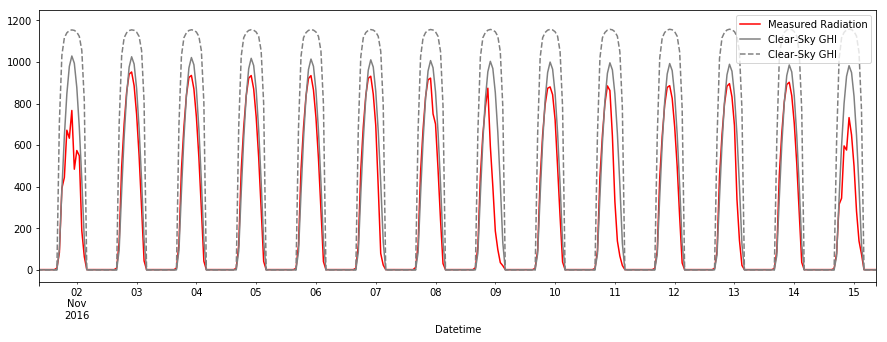

In [62]:
# Plot 10 days of irradiance vs clear sky to ensure correct time zone used
plt.figure(figsize=(15,5))
dfTSre['Radiation'].plot(color='red', label='Measured Radiation')
dfTSre['ghi'].plot(color='gray', label='Clear-Sky GHI')
dfTSre['dni'].plot(color='gray', ls='--', label='Clear-Sky GHI')
plt.xlim(left='2016-11-01 09:00:00', right='2016-11-15 09:00:00')
plt.legend(loc=1)

# Data Exploration

Items of note:
- clear daily cyclical trend.
- likely downward, semi-linear trend from Sep to Jan.
- missing data in middle of December.

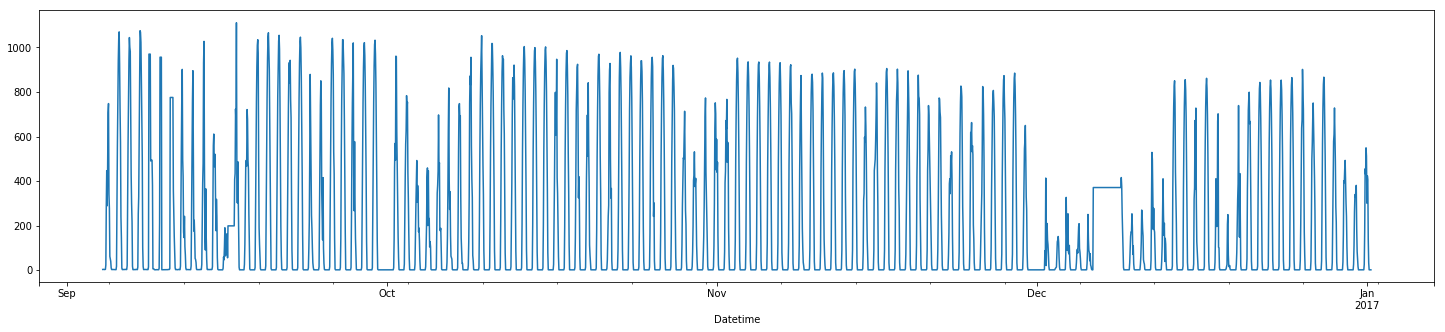

In [51]:
# Plot time series - clear seasonal variation to remove for ARIMA
fig = plt.figure(figsize=(25,5))
ax1 = fig.add_subplot(111)
dfTSre['Radiation'].plot(ax=ax1)

Test Statistic         -5.933779e+00
p-value                 2.346937e-07
Lags                    2.600000e+01
Observations            2.829000e+03
Critical Value (1%)    -3.432664e+00
Critical Value (5%)    -2.862562e+00
Critical Value (10%)   -2.567314e+00
dtype: float64


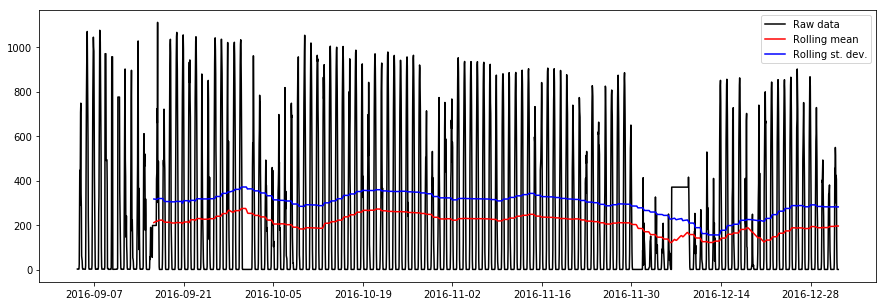

In [52]:
# Data already appears to be stationary (alternate hypothesis of Dickey-Fuller test) - no drift, do d=0
stationary_plot_and_test(dfTSre, 'Radiation')

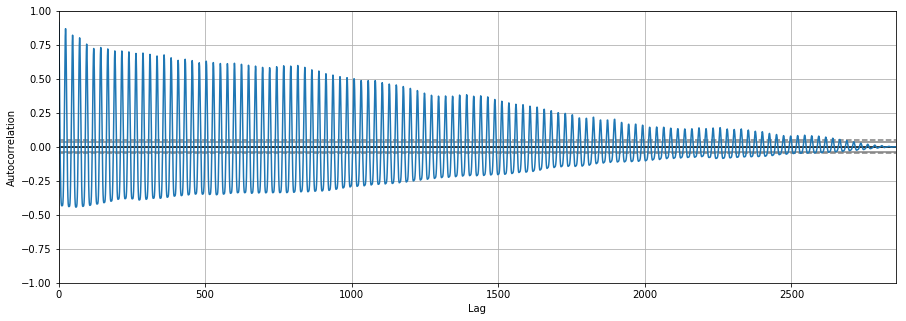

In [53]:
# Plot autocorrelation - long overall autocorrelation up to 20,000 lags but with seasonality by day
# Indicates need for SARIMAX
plt.figure(figsize=(15,5))
autocorrelation_plot(dfTSre['Radiation'])

(0, 750)

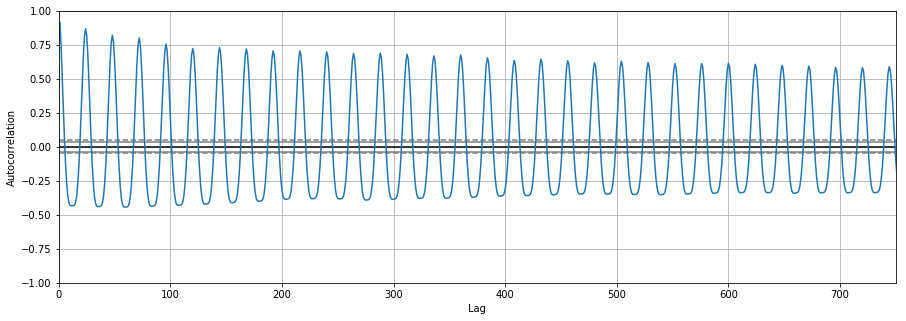

In [54]:
# Look at seasonality on shorter x-axis to determine 'm' value to use for SARIMA
# - about 280 lag steps
plt.figure(figsize=(15,5))
autocorrelation_plot(dfTSre['Radiation'])
plt.xlim(left=0, right=750)

In [55]:
# Check differencing
dfTimeDiff = pd.DataFrame((dfTSre.Radiation - dfTSre.Radiation.shift(1)).dropna())

Test Statistic         -1.676184e+01
p-value                 1.308226e-29
Lags                    2.500000e+01
Observations            2.829000e+03
Critical Value (1%)    -3.432664e+00
Critical Value (5%)    -2.862562e+00
Critical Value (10%)   -2.567314e+00
dtype: float64


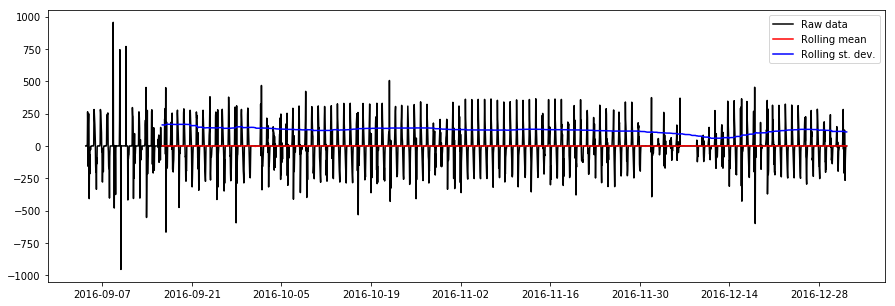

In [56]:
stationary_plot_and_test(dfTimeDiff, 'Radiation')

(0, 100)

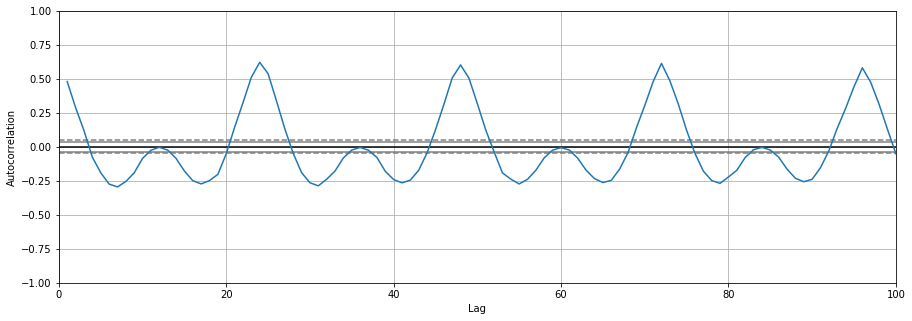

In [57]:
# Autocorrelation after differencing
plt.figure(figsize=(15,5))
autocorrelation_plot(dfTimeDiff['Radiation'])
plt.xlim(left=0, right=100)

# Baseline Model: Persistence

For 1-hour resampling of data, 0.5*(t-1)+0.5*(t-24) persistence model gives best result - RMSE=105.5 W/m2.

For 15-minute resampling of this data, t-1 persistence model minimizes MSE better than day before (96 lags).  Use this as naive baseline.

Steps      MSE
[1, 1]      15681.31
[1, 2]      27148.66
[1, 3]      39405.31
[1, 24]      11113.34


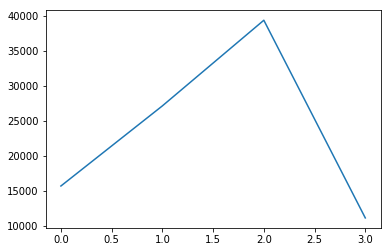

In [58]:
# Test different numbers of weighted steps
# just using previous 15 minute step appears best
tsPersist = dfTSre['Radiation']
weights = [0.5, 0.5]
listMSE = []
print('Steps      MSE')
for iStep in [[1, 1], [1, 2], [1, 3], [1, 24]]:
    tmpPersist, mse = persistence_model(tsPersist, iStep, weights)
    listMSE.append(mse)
    print('{0}      {1:.2f}'.format(iStep, mse))
plt.figure()
plt.plot(listMSE)

In [59]:
# Create final model - outPersist
tsPersist = dfTSre['Radiation']
steps = [1, 24]
weights = [0.5, 0.5]
outPersist, msePersist = persistence_model(tsPersist, steps, weights)
print("Persistence Model RMSE: {0:.2f}".format(np.sqrt(msePersist)))

Persistence Model RMSE: 105.42


(-750, 1300)

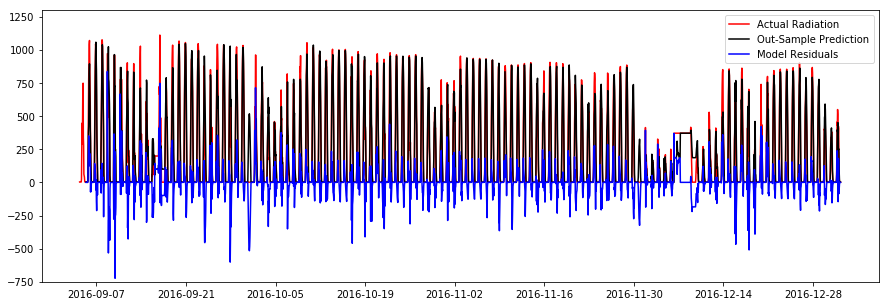

In [60]:
# Plot actuals, predictions, and residuals
plt.figure(figsize=(15,5))
plt.plot(dfTSre['Radiation'], color='red', label='Actual Radiation')
plt.plot(outPersist, color='black', label='Out-Sample Prediction')
plt.plot((dfTSre['Radiation'] - outPersist), color='blue', label='Model Residuals')
plt.legend()
plt.ylim(bottom=-750, top=1300)
#plt.xlim(left='2016-09-01', right='2016-09-04')

# SARIMAX Testing

- From parameters search, adding additional seasonal lags beyond two does not change RMSE at all.  Trend parameters have little impact, (3,0,0) minimizes error for low-value parameter search.
- with Exogenous variables, get more accurate forecast during day, but night-time becomes bumpier.  Get RMSE = 95 W/m2, about 10-12 W/m2 better than persistence forecast.
- (3,0,0)*(2,1,0,24) - best for 1-hour data.
- (3,0,0)*(1,1,0,96) - best so far for 15-minute data - need the d=1 for seasonal to lose drift in daily seasonal pattern
- Must use conserve_memory to avoid memory issues with SARIMAX for 15-minute intervals, however then forecast cannot be used.  Might not be possible with such long seasonal lag.
- Run into memory issue when reaching the 288 lags necessary for seasonality using 5-minute frequency dataset.  Statespace models in statsmodels package are written using dense LAPACK matrices, not sparse matrices, so run into memory issues more quickly than in something like scikit-learn.  This is likely because ARIMA/SARIMAX traditionally used for low-lag data (e.g. monthly data with 12-lag frequency for seasonality).



## Testing Fit and Parameters

In [30]:
# Select training size to use for testing model
testSizeSARIMAX = 0.15
trainSize = int((1 - testSizeSARIMAX)*len(dfTSre))
fcSize = len(dfTSre)-trainSize

# Set SARIMAX parmeters and select exogenous variables
ar=3
inte=0
ma=0
seasonalFreq=24
numFreq=2
colExog = ['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']

In [31]:
%%time
sarimax = SARIMAX(dfTSre['Radiation'].iloc[0:trainSize],
                  exog=dfTSre[colExog].iloc[0:trainSize].values,
                  order=(ar, inte, ma), seasonal_order=(numFreq, 1, 0, seasonalFreq))
#sarimax.set_conserve_memory()
sarimaxFit = sarimax.fit(disp=True)
print(sarimaxFit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Radiation   No. Observations:                 2427
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 24)   Log Likelihood              -13908.830
Date:                            Thu, 20 Dec 2018   AIC                          27839.661
Time:                                    14:25:42   BIC                          27903.290
Sample:                                09-04-2016   HQIC                         27862.807
                                     - 12-14-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            25.2327      0.918     27.487      0.000      23.434      27.032
x2          -659.8376     28.029   

In [32]:
# In-and-out-of-sample predictions
predictions = sarimaxFit.predict(start=(seasonalFreq*numFreq),
                            end=(trainSize+fcSize),
                            exog=dfTSre[colExog].iloc[trainSize-1:(trainSize+fcSize)].values,
                            typ='levels')
# Out-f-sample predictions
sarimaxFC = sarimaxFit.forecast(fcSize, exog=dfTSre[colExog].iloc[trainSize:(trainSize+fcSize)].values)

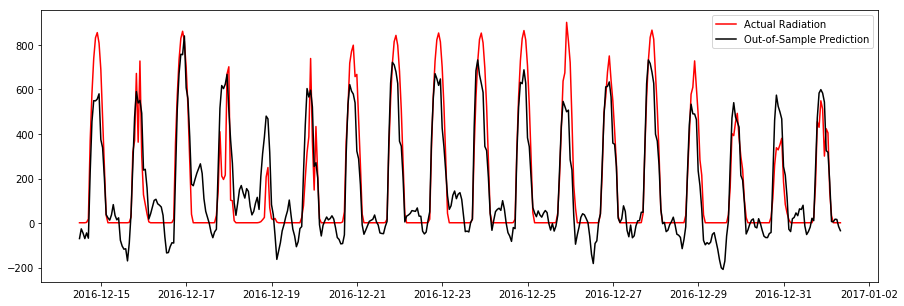

In [33]:
# Plot out-of-sample predictions vs actual only
plt.figure(figsize=(15,5))
plt.plot(dfTSre['Radiation'].iloc[trainSize:(trainSize+fcSize)], color='red', label='Actual Radiation')
plt.plot(sarimaxFC, color='black', label='Out-of-Sample Prediction')
plt.legend()

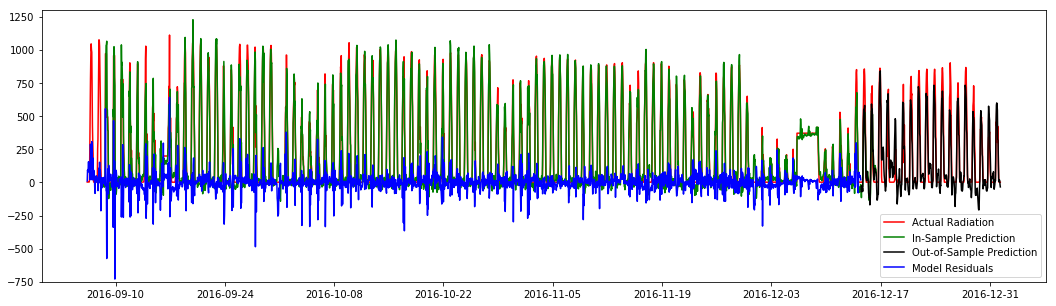

In [34]:
# Plot actuals, predictions, and residuals
dfResidSARIMAX = pd.DataFrame(sarimaxFit.resid, columns=['Residuals'])
plt.figure(figsize=(18,5))
plt.plot(dfTSre['Radiation'].iloc[(seasonalFreq*numFreq):(trainSize+fcSize)], color='red', label='Actual Radiation')
plt.plot(predictions.iloc[(seasonalFreq*numFreq):(trainSize)],
         color='green', label='In-Sample Prediction')
plt.plot(sarimaxFC, color='black', label='Out-of-Sample Prediction')
plt.plot(dfResidSARIMAX.iloc[(seasonalFreq*numFreq):(trainSize+fcSize)], color='blue', label='Model Residuals')
plt.ylim(bottom=-750, top=1300)
plt.legend()

In [35]:
# RMSE results
print('In-Sample RMSE: {0:.2f}'.format(np.sqrt(mean_squared_error(predictions.iloc[0:(trainSize-(seasonalFreq*numFreq))],
                           dfTSre['Radiation'].iloc[(seasonalFreq*numFreq):(trainSize)]))))
print('Out-of-Sample RMSE: {0:.2f}'.format(np.sqrt(mean_squared_error(predictions.iloc[(trainSize-(seasonalFreq*numFreq)):(trainSize+fcSize-(seasonalFreq*numFreq))],
                           dfTSre['Radiation'].iloc[(trainSize):(trainSize+fcSize)]))))

In-Sample RMSE: 76.47
Out-of-Sample RMSE: 130.65


Residuals    0.835594
dtype: float64


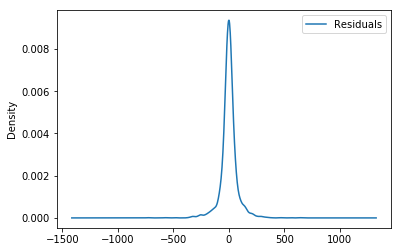

In [36]:
# plot kde of errors - mean at 0 and looks almost lorentzian?
print(dfResidSARIMAX.iloc[(seasonalFreq*numFreq):(trainSize+fcSize)].mean())
dfResidSARIMAX.iloc[(seasonalFreq*numFreq):(trainSize+fcSize)].plot(kind='kde')

# Modeling

## Create training and test sets

In [63]:
# Create features df
colExcludeFeat = ['Radiation']
colFeat = [item for item in dfTSre.columns if item not in colExcludeFeat]
dfFeat = dfTSre[colFeat]

# Create target df
dfTarget = dfTSre['Radiation']

In [64]:
# Create training and test sets
featTrain, featTest, targTrain, targTest = train_test_split(dfFeat, dfTarget,
                                                            test_size=0.20, shuffle=True)

In [68]:
# Scale data
sScaler = StandardScaler()
sScaler.fit(featTrain)
featTrainS = pd.DataFrame(sScaler.transform(featTrain), columns=featTrain.columns)
featTestS = pd.DataFrame(sScaler.transform(featTest), columns=featTest.columns)

### Alernative Method: Routine for creating multiple test sets using day-ahead forecast for final error measurement (used within each model subsection below)

Use TimeSeriesSplit to create ever-increasing training sets that are supersets of previous training data.  Then test set is a fixed size interval directly after end of training data range.  Use validation set within each training data for hyperparameter optimization, then average all test set errors for final error prediction.

<img src="2KHMQ.png">

## Light-GBM

- 70-75 W/m2 RMSE in test data outperforms persistence by 30-35 W/m2 and SARIMAX by 20-25 W/m2.
- Learning curve suggests we have enough training samples, and additional features would be required to improve model (based on plateauing of both training and test data).

In [69]:
def search_results_update_lgb(optim_result):
    '''
    Provides updated parameter values during Bayesian hyperparameter search.
    '''
    # Return models completed so far in search
    models = pd.DataFrame(gridBayesLGB.cv_results_)
    
    # Get best parameters at that point
    print('Model {}:\nScore: {}\nBest Parameters: {}\n'.format(
        len(models),
        np.round(gridBayesLGB.best_score_, 3),
        gridBayesLGB.best_params_
     ))

In [70]:
%%time
# Create LGB regressor object
lgb = LGBMRegressor(boosting_type='gbdt')

# Set search space for BayesSearchCV
searchSpaceLGB = {'n_estimators': (50, 500),
                'num_leaves': (10,100),
                'max_depth': (1,10),
                'learning_rate': (0.001, 1, 'log-uniform'),
                'min_child_samples': (1,10),
                'subsample': (0.1, 1.0, 'uniform'),
                'subsample_freq': (0, 100),
                'colsample_bytree': (0.1, 1.0, 'uniform')
                }

gridBayesLGB = BayesSearchCV(
    estimator=lgb,
    search_spaces=searchSpaceLGB,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=15,
    return_train_score=True,
    n_jobs=1
)

# Begin Bayesian search with callback function given above
gridBayesLGB.fit(featTrain, targTrain, callback=search_results_update_lgb)
print('Validation RMSE: {0:.2f}'.format(np.sqrt(np.abs(gridBayesLGB.best_score_))))

Model 1:
Score: -13720.367
Best Parameters: {'colsample_bytree': 0.7935311684961133, 'learning_rate': 0.002720042212698185, 'max_depth': 5, 'min_child_samples': 5, 'n_estimators': 433, 'num_leaves': 81, 'subsample': 0.6603223871062603, 'subsample_freq': 49}

Model 2:
Score: -5028.916
Best Parameters: {'colsample_bytree': 0.6357467305204851, 'learning_rate': 0.11424104130263449, 'max_depth': 4, 'min_child_samples': 7, 'n_estimators': 269, 'num_leaves': 39, 'subsample': 0.9192319863331531, 'subsample_freq': 33}

Model 3:
Score: -4963.764
Best Parameters: {'colsample_bytree': 0.8645970253458273, 'learning_rate': 0.011155594846424543, 'max_depth': 9, 'min_child_samples': 9, 'n_estimators': 289, 'num_leaves': 79, 'subsample': 0.7789882814696744, 'subsample_freq': 97}

Model 4:
Score: -4963.764
Best Parameters: {'colsample_bytree': 0.8645970253458273, 'learning_rate': 0.011155594846424543, 'max_depth': 9, 'min_child_samples': 9, 'n_estimators': 289, 'num_leaves': 79, 'subsample': 0.778988281

In [72]:
# Final Fitting
lgbF = LGBMRegressor(boosting_type='gbdt',
                     colsample_bytree=0.86,
                     learning_rate= 0.01,
                     max_depth=9,
                     min_child_samples=9,
                     n_estimators=289,
                     num_leaves=79,
                     subsample=0.78,
                     subsample_freq=97)
lgbF.fit(featTrain, targTrain)
print('Out-of-Sample RMSE: {0:.2f}'.format(np.sqrt(mean_squared_error(targTest, lgbF.predict(featTest)))))

Out-of-Sample RMSE: 81.11


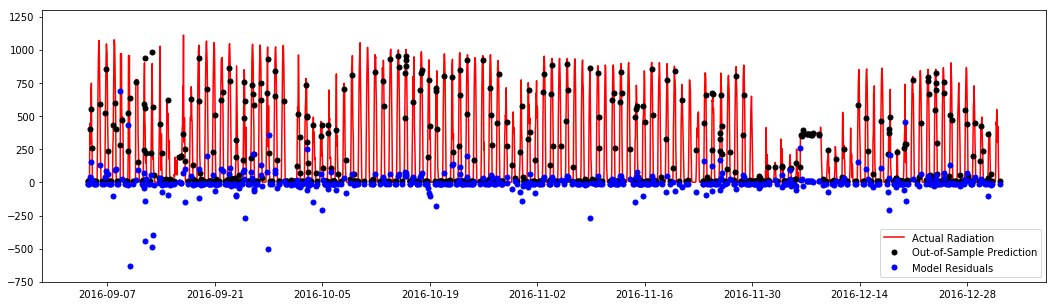

In [73]:
# Calculate test residuals
dfResidLGB = pd.Series((targTest-lgbF.predict(featTest)), index=targTest.index)

# Plot actuals, predictions, and residuals
plt.figure(figsize=(18,5))
plt.plot(dfTSre['Radiation'], color='red', label='Actual Radiation')
plt.plot(pd.Series(lgbF.predict(featTest), index=targTest.index), marker='o', markersize=5,
         ls='None', color='black', label='Out-of-Sample Prediction')
plt.plot(dfResidLGB, color='blue', marker='o', markersize=5, ls='None', label='Model Residuals')
plt.ylim(bottom=-750, top=1300)
plt.legend()

-1.2180956714993534


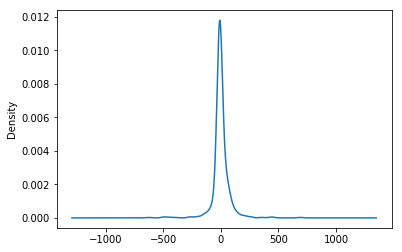

In [74]:
# plot kde of errors - mean at 0 and looks almost lorentzian?
print(dfResidLGB.mean())
dfResidLGB.plot(kind='kde')

Text(0,0.5,'Feature')

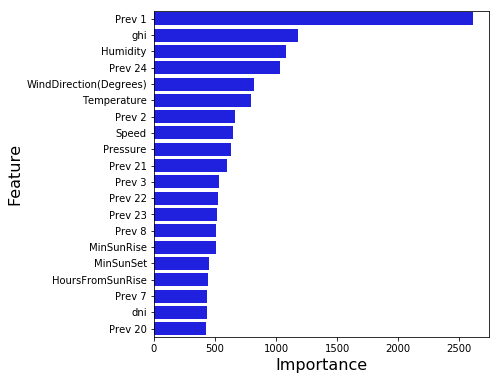

In [75]:
# Put feature importances into df and plot
dfImpLGB = pd.DataFrame({'Feature': dfFeat.columns.tolist(),
                      'Importance': lgbF.feature_importances_})
dfImpLGB = dfImpLGB.sort_values('Importance', ascending=False)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sns.barplot(x="Importance", y="Feature", data=dfImpLGB[0:20], color='b')
ax.set_xlabel("Importance", fontsize=16)
ax.set_ylabel("Feature", fontsize=16)

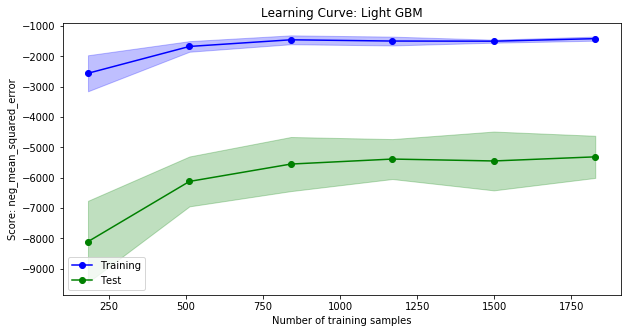

In [76]:
# Learning curve
trainSizes = np.linspace(0.1,1,6)
scorerLC = 'neg_mean_squared_error'
cvSS = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
trainSizeLGBlc, trainScoreLGBlc, valScoreLGBlc = learning_curve_plot(model=lgbF,
                                                                     features=featTrain, target=targTrain,
                                                                     trainFracs=trainSizes, 
                                                                     cvModel=cvSS,
                                                                     scorer=scorerLC,
                                                                     nJobs=1, plotTitle='Light GBM')

### Nested time-series cross-validation (proper method to determine test error)

In [44]:
# For day-ahead test sets only, use 119 splits
len(dfTSre)/119

24.0

In [112]:
nSplits=119
nCV=5
nIter=10
predLGB, residLGB, rmseLGB, bestParamsLGB = time_series_split_and_cv(dfFeat, dfTarget, nSplits=nSplits,
                                                           model=LGBMRegressor(boosting_type='gbdt'),
                                                           searchSpace = {'n_estimators': (50, 500),
                                                                            'num_leaves': (10,100),
                                                                            'max_depth': (1,10),
                                                                            'learning_rate': (0.001, 1, 'log-uniform'),
                                                                            'min_child_samples': (1,10),
                                                                            'subsample': (0.1, 1.0, 'uniform'),
                                                                            'subsample_freq': (0, 100),
                                                                            'colsample_bytree': (0.1, 1.0, 'uniform')
                                                                            },
                                                           nCV=nCV, nIter=nIter,
                                                           scaled=False
                                                          )

Split 1 Best Parameters: {'colsample_bytree': 0.9121198173027489, 'learning_rate': 0.5035451019202242, 'max_depth': 2, 'min_child_samples': 2, 'n_estimators': 65, 'num_leaves': 47, 'subsample': 0.848138442128541, 'subsample_freq': 65}
Split 1 Test RMSE: 207.38
Split 2 Best Parameters: {'colsample_bytree': 0.7632785622335853, 'learning_rate': 0.3822205195601943, 'max_depth': 4, 'min_child_samples': 9, 'n_estimators': 415, 'num_leaves': 30, 'subsample': 0.9552119362069811, 'subsample_freq': 80}
Split 2 Test RMSE: 101.79
Split 3 Best Parameters: {'colsample_bytree': 0.34840559550194516, 'learning_rate': 0.008301741784036629, 'max_depth': 3, 'min_child_samples': 2, 'n_estimators': 400, 'num_leaves': 23, 'subsample': 0.66252768182722, 'subsample_freq': 97}
Split 3 Test RMSE: 184.74
Split 4 Best Parameters: {'colsample_bytree': 0.8077417610254286, 'learning_rate': 0.06563622956544916, 'max_depth': 8, 'min_child_samples': 5, 'n_estimators': 142, 'num_leaves': 47, 'subsample': 0.59939688438225

Split 32 Best Parameters: {'colsample_bytree': 0.7610201687034808, 'learning_rate': 0.00917519764016813, 'max_depth': 7, 'min_child_samples': 9, 'n_estimators': 298, 'num_leaves': 59, 'subsample': 0.6616571643623542, 'subsample_freq': 54}
Split 32 Test RMSE: 39.80
Split 33 Best Parameters: {'colsample_bytree': 0.41306085649798463, 'learning_rate': 0.008872820170398308, 'max_depth': 9, 'min_child_samples': 3, 'n_estimators': 436, 'num_leaves': 42, 'subsample': 0.7077279500989543, 'subsample_freq': 68}
Split 33 Test RMSE: 38.22
Split 34 Best Parameters: {'colsample_bytree': 0.9661875297545133, 'learning_rate': 0.01294373352992702, 'max_depth': 1, 'min_child_samples': 4, 'n_estimators': 404, 'num_leaves': 94, 'subsample': 0.9076684864310233, 'subsample_freq': 42}
Split 34 Test RMSE: 66.80
Split 35 Best Parameters: {'colsample_bytree': 0.8118761651475964, 'learning_rate': 0.0046652149971066915, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 449, 'num_leaves': 72, 'subsample': 0.3

Split 62 Test RMSE: 42.69
Split 63 Best Parameters: {'colsample_bytree': 0.7274100583648462, 'learning_rate': 0.08905566865579516, 'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 74, 'num_leaves': 78, 'subsample': 0.744170158248104, 'subsample_freq': 9}
Split 63 Test RMSE: 36.72
Split 64 Best Parameters: {'colsample_bytree': 0.673831973998759, 'learning_rate': 0.011191394192171083, 'max_depth': 9, 'min_child_samples': 1, 'n_estimators': 377, 'num_leaves': 20, 'subsample': 0.5819327912608796, 'subsample_freq': 12}
Split 64 Test RMSE: 93.34
Split 65 Best Parameters: {'colsample_bytree': 0.9432939078296917, 'learning_rate': 0.012773621950860143, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 379, 'num_leaves': 80, 'subsample': 0.5452745804332769, 'subsample_freq': 56}
Split 65 Test RMSE: 63.87
Split 66 Best Parameters: {'colsample_bytree': 0.7893600963918309, 'learning_rate': 0.014086967795001215, 'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 305, 'num_leaves':

Split 93 Test RMSE: 49.28
Split 94 Best Parameters: {'colsample_bytree': 0.7216151297719654, 'learning_rate': 0.008823918107852163, 'max_depth': 8, 'min_child_samples': 6, 'n_estimators': 262, 'num_leaves': 92, 'subsample': 0.8592172669060356, 'subsample_freq': 1}
Split 94 Test RMSE: 20.88
Split 95 Best Parameters: {'colsample_bytree': 0.9277597592359967, 'learning_rate': 0.10508738333787612, 'max_depth': 7, 'min_child_samples': 8, 'n_estimators': 227, 'num_leaves': 92, 'subsample': 0.8926469367323489, 'subsample_freq': 87}
Split 95 Test RMSE: 153.17
Split 96 Best Parameters: {'colsample_bytree': 0.8911727155004066, 'learning_rate': 0.010382017635487613, 'max_depth': 4, 'min_child_samples': 9, 'n_estimators': 367, 'num_leaves': 84, 'subsample': 0.6136985419289465, 'subsample_freq': 53}
Split 96 Test RMSE: 81.47
Split 97 Best Parameters: {'colsample_bytree': 0.9001754218425622, 'learning_rate': 0.029748922344524625, 'max_depth': 7, 'min_child_samples': 9, 'n_estimators': 204, 'num_leave

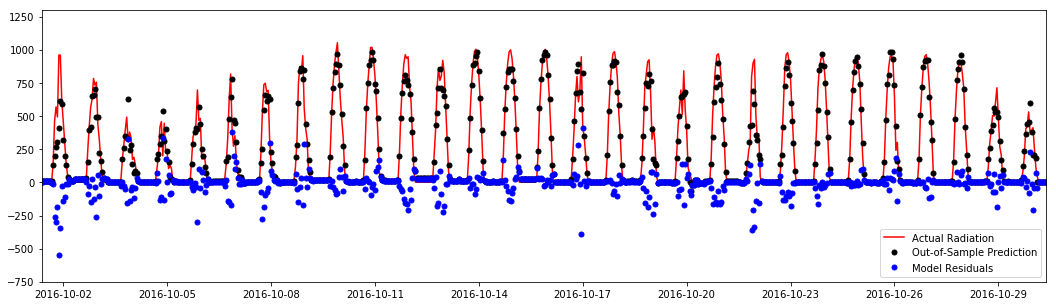

In [113]:
# Plot actuals, predictions, and residuals - use xlim to set date range
plt.figure(figsize=(18,5))
plt.plot(dfTSre['Radiation'], color='red', label='Actual Radiation')
plt.plot(predLGB, marker='o', markersize=5,
         ls='None', color='black', label='Out-of-Sample Prediction')
plt.plot(residLGB, color='blue', marker='o', markersize=5, ls='None', label='Model Residuals')
plt.ylim(bottom=-750, top=1300)
plt.xlim(left='2016-10-01 09:00:00', right='2016-10-30 09:00:00')
plt.legend()

1.9123422102876093


Text(0.5,1,'RMSE vs Test Set Number')

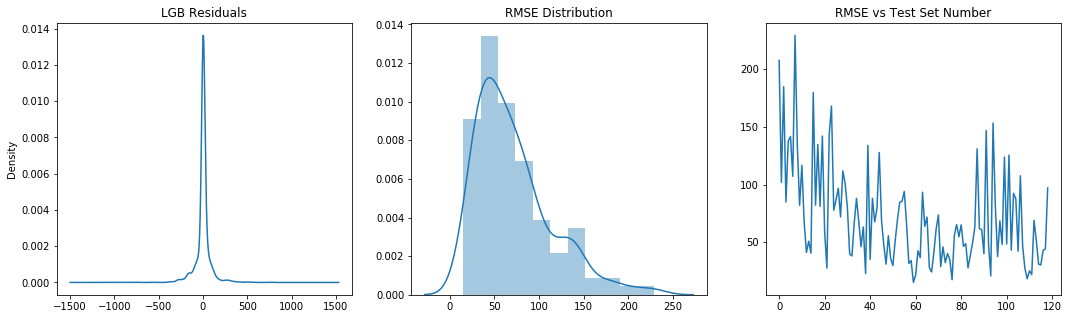

In [114]:
# plot RMSE histogram and KDE of residuals - mean at 0 and looks almost lorentzian?
print(residLGB.mean())
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
residLGB.plot(kind='kde', title='LGB Residuals', ax=ax1)
sns.distplot(rmseLGB, ax=ax2)
ax2.set_title('RMSE Distribution')
ax3.plot(rmseLGB)
ax3.set_title('RMSE vs Test Set Number')

## Neural Network

In [77]:
def search_results_update_ann(optim_result):
    '''
    Provides updated parameter values during Bayesian hyperparameter search.
    '''
    # Return models completed so far in search
    models = pd.DataFrame(gridBayesANN.cv_results_)
    
    # Get best parameters at that point
    print('Model {}:\nScore: {}\nBest Parameters: {}\n'.format(
        len(models),
        np.round(gridBayesANN.best_score_, 3),
        gridBayesANN.best_params_
     ))

In [107]:
%%time
# Create NN object
ann = MLPRegressor(activation='relu', solver='adam',
                   hidden_layer_sizes=(100, 100, 50,))

# Set search space for BayesSearchCV - can't use Bayes search to optimize number of hidden layers or size
searchSpaceANN = {
                'activation': ['identity', 'relu', 'logistic', 'tanh'],
                'alpha': (0.0001, 10, 'log-uniform'),
                'learning_rate_init': (0.001, 1, 'log-uniform'),
                }

gridBayesANN = BayesSearchCV(
    estimator=ann,
    search_spaces=searchSpaceANN,
    cv=5,
    scoring='neg_mean_squared_error',
    n_iter=20,
    return_train_score=True,
    n_jobs=1
)

# Begin Bayesian search with callback function given above
gridBayesANN.fit(featTrainS, targTrain, callback=search_results_update_ann)
print('Validation RMSE: {0:.2f}'.format(np.sqrt(np.abs(gridBayesANN.best_score_))))

Model 1:
Score: -9532.399
Best Parameters: {'activation': 'tanh', 'alpha': 4.037043189520893, 'learning_rate_init': 0.08714286643073138}

Model 2:
Score: -5435.81
Best Parameters: {'activation': 'relu', 'alpha': 0.13032335048408686, 'learning_rate_init': 0.003042711975414056}

Model 3:
Score: -5435.81
Best Parameters: {'activation': 'relu', 'alpha': 0.13032335048408686, 'learning_rate_init': 0.003042711975414056}

Model 4:
Score: -5435.81
Best Parameters: {'activation': 'relu', 'alpha': 0.13032335048408686, 'learning_rate_init': 0.003042711975414056}

Model 5:
Score: -5257.448
Best Parameters: {'activation': 'relu', 'alpha': 0.016470064031476335, 'learning_rate_init': 0.0024280710212987054}

Model 6:
Score: -5257.448
Best Parameters: {'activation': 'relu', 'alpha': 0.016470064031476335, 'learning_rate_init': 0.0024280710212987054}

Model 7:
Score: -5257.448
Best Parameters: {'activation': 'relu', 'alpha': 0.016470064031476335, 'learning_rate_init': 0.0024280710212987054}

Model 8:
Scor

In [108]:
# Final Fitting
annF = MLPRegressor(activation='relu', solver='adam',
                   hidden_layer_sizes=(100, 100, 50,),
                   alpha=0.016,
                   learning_rate_init=0.002)
annF.fit(featTrainS, targTrain)
print('Out-of-Sample RMSE: {0:.2f}'.format(np.sqrt(mean_squared_error(targTest, annF.predict(featTestS)))))

Out-of-Sample RMSE: 84.40


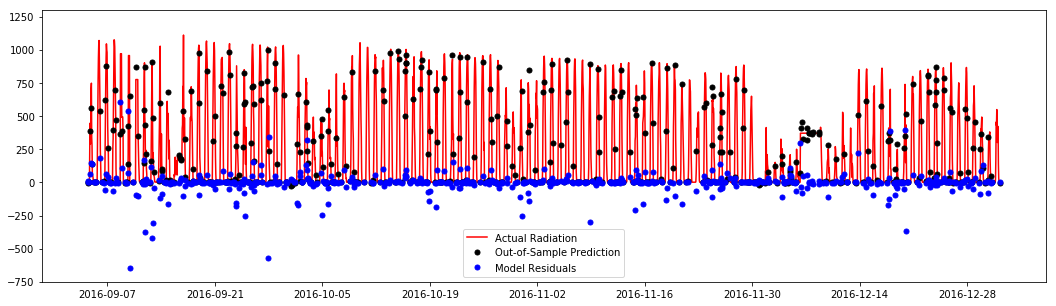

In [109]:
# Calculate test residuals
dfResidANN = pd.Series((targTest-annF.predict(featTestS)), index=targTest.index)

# Plot actuals, predictions, and residuals
plt.figure(figsize=(18,5))
plt.plot(dfTSre['Radiation'], color='red', label='Actual Radiation')
plt.plot(pd.Series(annF.predict(featTestS), index=targTest.index), marker='o', markersize=5,
         ls='None', color='black', label='Out-of-Sample Prediction')
plt.plot(dfResidANN, color='blue', marker='o', markersize=5, ls='None', label='Model Residuals')
plt.ylim(bottom=-750, top=1300)
plt.legend()

-0.9737458199404855


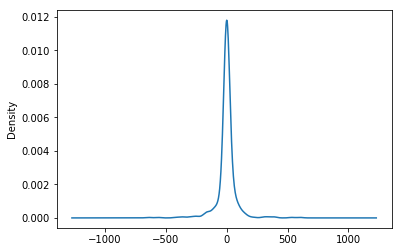

In [110]:
# plot kde of errors
print(dfResidANN.mean())
dfResidANN.plot(kind='kde')

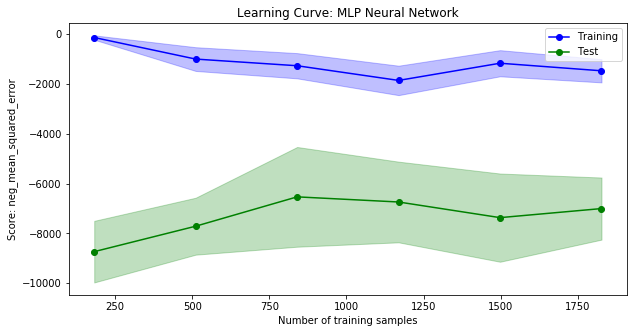

In [111]:
# Learning curve
trainSizes = np.linspace(0.1,1,6)
scorerLC = 'neg_mean_squared_error'
cvSS = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
trainSizeANNlc, trainScoreANNlc, valScoreANNlc = learning_curve_plot(model=annF,
                                                                     features=featTrain, target=targTrain,
                                                                     trainFracs=trainSizes, 
                                                                     cvModel=cvSS,
                                                                     scorer=scorerLC,
                                                                     nJobs=1, plotTitle='MLP Neural Network')

### Nested Cross-validation for ANN

In [116]:
nSplits=119
nCV=5
nIter=15
predANN, residANN, rmseANN, bestParamsANN = time_series_split_and_cv(dfFeat, dfTarget, nSplits=nSplits,
                                                           model=MLPRegressor(activation='relu', solver='adam',
                                                                              hidden_layer_sizes=(100, 100, 50,)),
                                                           searchSpace = {
                                                                        'activation': ['identity', 'relu', 'logistic', 'tanh'],
                                                                        'alpha': (0.0001, 10, 'log-uniform'),
                                                                        'learning_rate_init': (0.001, 1, 'log-uniform'),
                                                                        }, 
                                                           nCV=nCV, nIter=nIter,
                                                           scaled=True
                                                          )

Split 1 Best Parameters: {'activation': 'relu', 'alpha': 0.6630169325741806, 'learning_rate_init': 0.016601340903570724}
Split 1 Test RMSE: 183.75
Split 2 Best Parameters: {'activation': 'relu', 'alpha': 0.0038814609011728336, 'learning_rate_init': 0.022584096599523335}
Split 2 Test RMSE: 142.37
Split 3 Best Parameters: {'activation': 'tanh', 'alpha': 6.831666218901744, 'learning_rate_init': 0.27674340800868436}
Split 3 Test RMSE: 151.88
Split 4 Best Parameters: {'activation': 'identity', 'alpha': 0.2007732131825849, 'learning_rate_init': 0.0010365519721839721}
Split 4 Test RMSE: 136.94
Split 5 Best Parameters: {'activation': 'identity', 'alpha': 1.1805661542323502, 'learning_rate_init': 0.005664396521790196}
Split 5 Test RMSE: 162.59
Split 6 Best Parameters: {'activation': 'relu', 'alpha': 0.04038560831432644, 'learning_rate_init': 0.002214907469944719}
Split 6 Test RMSE: 68.76
Split 7 Best Parameters: {'activation': 'identity', 'alpha': 0.0003851364112749411, 'learning_rate_init': 0.

Split 55 Test RMSE: 90.76
Split 56 Best Parameters: {'activation': 'identity', 'alpha': 0.02051436636257409, 'learning_rate_init': 0.0017433408259636366}
Split 56 Test RMSE: 95.00
Split 57 Best Parameters: {'activation': 'identity', 'alpha': 0.008279007395995557, 'learning_rate_init': 0.0037885079989865436}
Split 57 Test RMSE: 73.48
Split 58 Best Parameters: {'activation': 'tanh', 'alpha': 0.034175389635679905, 'learning_rate_init': 0.03802546085798549}
Split 58 Test RMSE: 53.25
Split 59 Best Parameters: {'activation': 'identity', 'alpha': 0.002815104794020555, 'learning_rate_init': 0.002615492836577972}
Split 59 Test RMSE: 62.08
Split 60 Best Parameters: {'activation': 'identity', 'alpha': 0.003677694024311398, 'learning_rate_init': 0.0012752143962079566}
Split 60 Test RMSE: 45.39
Split 61 Best Parameters: {'activation': 'identity', 'alpha': 9.84402443246865, 'learning_rate_init': 0.0037728004657166542}
Split 61 Test RMSE: 43.22
Split 62 Best Parameters: {'activation': 'relu', 'alpha'

Split 109 Test RMSE: 40.15
Split 110 Best Parameters: {'activation': 'identity', 'alpha': 0.18647986559245877, 'learning_rate_init': 0.020500728944014966}
Split 110 Test RMSE: 40.55
Split 111 Best Parameters: {'activation': 'identity', 'alpha': 0.0451950734697296, 'learning_rate_init': 0.023752153218373196}
Split 111 Test RMSE: 37.37
Split 112 Best Parameters: {'activation': 'identity', 'alpha': 0.00016104027811313104, 'learning_rate_init': 0.0016840100386050865}
Split 112 Test RMSE: 59.17
Split 113 Best Parameters: {'activation': 'identity', 'alpha': 0.10450409918959881, 'learning_rate_init': 0.003563043633442721}
Split 113 Test RMSE: 58.80
Split 114 Best Parameters: {'activation': 'identity', 'alpha': 0.02834436119468278, 'learning_rate_init': 0.047706028037984675}
Split 114 Test RMSE: 48.35
Split 115 Best Parameters: {'activation': 'identity', 'alpha': 0.030517181714943695, 'learning_rate_init': 0.003390722146183284}
Split 115 Test RMSE: 40.97
Split 116 Best Parameters: {'activation

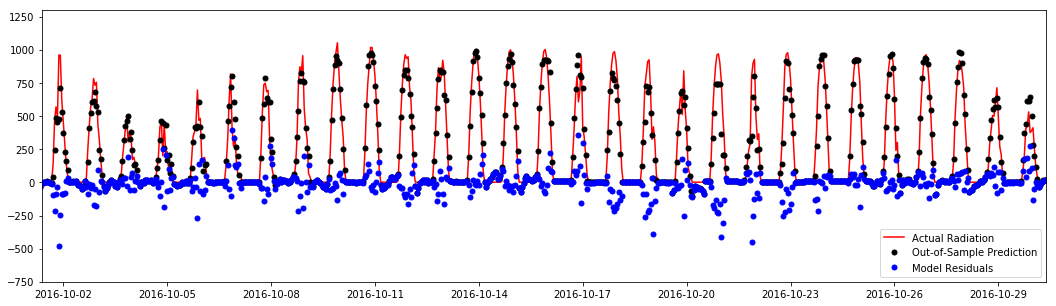

In [117]:
# Plot actuals, predictions, and residuals - use xlim to set date range
plt.figure(figsize=(18,5))
plt.plot(dfTSre['Radiation'], color='red', label='Actual Radiation')
plt.plot(predANN, marker='o', markersize=5,
         ls='None', color='black', label='Out-of-Sample Prediction')
plt.plot(residANN, color='blue', marker='o', markersize=5, ls='None', label='Model Residuals')
plt.ylim(bottom=-750, top=1300)
plt.xlim(left='2016-10-01 09:00:00', right='2016-10-30 09:00:00')
plt.legend()

-7.285283541365752


Text(0.5,1,'RMSE vs Test Set Number')

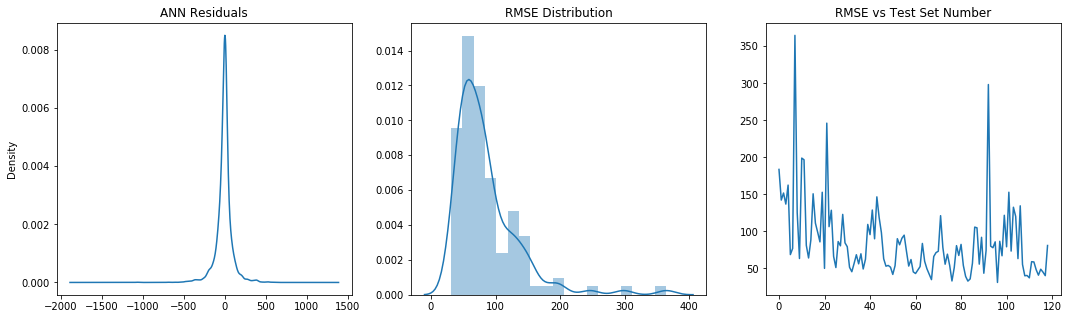

In [118]:
# plot RMSE histogram and KDE of residuals - mean at 0 and looks almost lorentzian?
print(residANN.mean())
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
residANN.plot(kind='kde', title='ANN Residuals', ax=ax1)
sns.distplot(rmseANN, ax=ax2)
ax2.set_title('RMSE Distribution')
ax3.plot(rmseANN)
ax3.set_title('RMSE vs Test Set Number')

In [119]:
print(np.median(rmseANN))
print(np.median(rmseLGB))

73.25379727385973
63.24460948743501
